Inital EDA walkthrough for the GoodReads dataset. I'm also intereseted in seeing how to create embeddings for each title

In [1]:
import numpy as np
import pandas as pd

Load in the data

In [2]:
df_books = pd.read_csv('data_GoodReads/books_data.csv')

df_books.iloc[3]['description']

'Julia Thomas finds her life spinning out of control after the death of her husband, Richard. Julia turns to her minister for comfort when she finds herself falling for him with a passion that is forbidden by the church. Heath Sparks is a man of God who is busy taking care of his quadriplegic wife who was seriously injured in a sever car accident. In an innocent effort to reach out to a lonely member of his church, Heath finds himself as the man and not the minister as Heath and Julia surrender their bodies to each other and face the wrath of God. Julia finds herself in over her head as she faces a deadly disease, the loss of her home and whispers about her wicked affair. Julia leaves the states offering her body as a living sacrifice in hopes of finding a cure while her heart remains thousands of miles away hoping to one day reunite with the man who holds it hostage.Whispers of the Wicked Saints is a once in a lifetime romance that is breath taking, defying all the rules of romance an

In [3]:
df_reviews = pd.read_csv('data_GoodReads/Books_rating.csv')

df_reviews.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [4]:
df_books.shape, df_reviews.shape

((212404, 10), (3000000, 10))

In [5]:
len(list(set(df_reviews['Title'])))

212404

In [6]:
set(df_reviews['review/score'])

{1.0, 2.0, 3.0, 4.0, 5.0}

In [7]:
review_counts = df_reviews.groupby('Title')['Title'].count().reset_index(name='Review Count').sort_values(by='Review Count', ascending=False)

review_counts

,Title,Review Count
166774,The Hobbit,22023
123882,Pride and Prejudice,20371
17627,Atlas Shrugged,12513
210378,Wuthering Heights,10780
164672,The Giver,7644
...,...,...
79456,In Darwin's Wake: Revisiting Beagle's South Am...,1
79454,In Darkest Germany,1
79453,In Darkest Africa or the Quest Rescue and Retr...,1
79449,In Coronado's footsteps,1


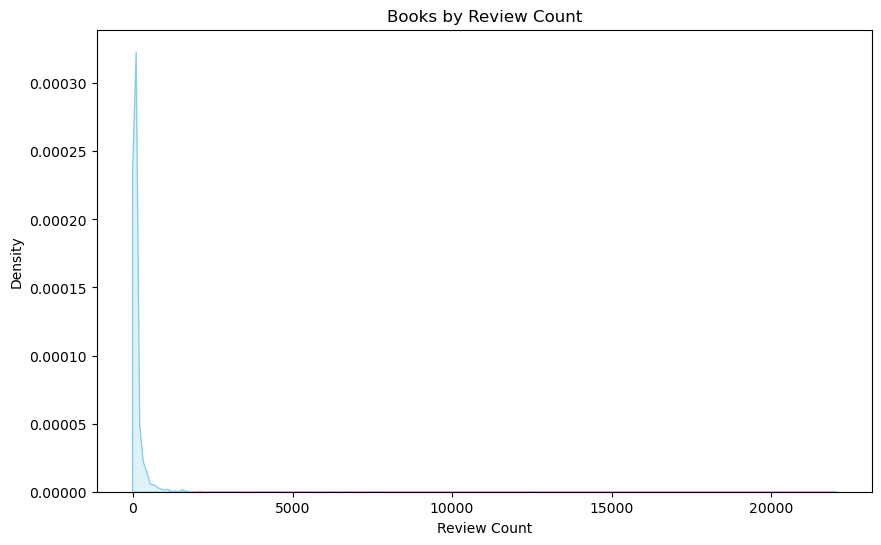

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(review_counts['Review Count'], fill=True, color='skyblue')
plt.xlabel('Review Count')
plt.ylabel('Density')
plt.title('Books by Review Count')
plt.show()

In [9]:
np.percentile(review_counts['Review Count'], 90)

21.0

Create embeddings for each book using the users' reviews of it and any additional info

In [10]:
df_reviews['review/summary'] = df_reviews['review/summary'].fillna("").astype(str)

In [11]:
# Step 1: Sort reviews by helpfulness in descending order before grouping
combined_reviews_df = (
    df_reviews
    .sort_values(by='review/helpfulness', ascending=False)  # Sort by helpfulness
    .groupby('Title')['review/summary']  # Group by book title
    .apply(lambda x: " ".join(x))  # Concatenate reviews
    .reset_index()  # Reset index to create a DataFrame
    .rename(columns={'review/summary': 'combined_reviews'})  # Rename column to 'combined_reviews'
)

In [12]:
merged_df = df_books.merge(combined_reviews_df, on='Title', how='left')

In [13]:
merged_df['authors'] = merged_df['authors'].fillna('').astype(str)
merged_df['description'] = merged_df['description'].fillna('').astype(str)
merged_df['combined_reviews'] = merged_df['combined_reviews'].fillna('')

In [14]:
def fix_names(authors):

    authors = authors.strip("[]").replace("'", "").split(', ')

    return " ".join(authors)

In [15]:
merged_df['authors'] = merged_df['authors'].apply(fix_names)

In [16]:
merged_df['book_info'] = (
    merged_df['Title'] + " " +
    merged_df['authors'] + " " +
    merged_df['description'] + " " +
    merged_df['combined_reviews']
)

In [18]:
merged_df.iloc[3]['book_info']

"Whispers of the Wicked Saints Veronica Haddon Julia Thomas finds her life spinning out of control after the death of her husband, Richard. Julia turns to her minister for comfort when she finds herself falling for him with a passion that is forbidden by the church. Heath Sparks is a man of God who is busy taking care of his quadriplegic wife who was seriously injured in a sever car accident. In an innocent effort to reach out to a lonely member of his church, Heath finds himself as the man and not the minister as Heath and Julia surrender their bodies to each other and face the wrath of God. Julia finds herself in over her head as she faces a deadly disease, the loss of her home and whispers about her wicked affair. Julia leaves the states offering her body as a living sacrifice in hopes of finding a cure while her heart remains thousands of miles away hoping to one day reunite with the man who holds it hostage.Whispers of the Wicked Saints is a once in a lifetime romance that is brea

Now that we have the composite information for each book, we can move into creating embeddings for each book. We'll want to start out by further preprocessing each 'book_info' to remove uncessary and confusing tokens before passing it into a transformer to generate our embeddings

In [19]:
merged_df

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,combined_reviews,book_info
0,Its Only Art If Its Well Hung!,,Julie Strain,http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN,Nice collection of Julie Strain images,Its Only Art If Its Well Hung! Julie Strain N...
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,Phlip Nel gives silly Seuss a serious treatmen...,Dr. Seuss: American Icon Philip Nel Philip Nel...
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,David R. Ray,http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN,Outstanding Resource for Small Church Pastors ...,Wonderful Worship in Smaller Churches David R....
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,Veronica Haddon,http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN,Couldn't put this book down! not good awful be...,Whispers of the Wicked Saints Veronica Haddon ...
4,"Nation Dance: Religion, Identity and Cultural ...",,Edward Long,NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN,interplay of traditions across Caribbean,"Nation Dance: Religion, Identity and Cultural ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
212399,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",Elvira Woodruff,http://books.google.com/books/content?id=J7M-N...,http://books.google.com/books?id=J7M-NwAACAAJ&...,Scholastic Paperbacks,2000-06-01,http://books.google.com/books?id=J7M-NwAACAAJ&...,['Juvenile Fiction'],2.0,Even reluctant readers love this book. It&#655...,The Orphan Of Ellis Island (Time Travel Advent...
212400,Red Boots for Christmas,Everyone in the village of Friedensdorf is hap...,,http://books.google.com/books/content?id=3n8k6...,http://books.google.com/books?id=3n8k6wl4BbYC&...,NaN,1995,http://books.google.com/books?id=3n8k6wl4BbYC&...,['Juvenile Fiction'],NaN,A wonderful way to share the miracle of Christ...,Red Boots for Christmas Everyone in the villa...
212401,Mamaw,"Give your Mamaw a useful, beautiful and though...",Wild Wild Cabbage,NaN,http://books.google.com/books?id=zytVswEACAAJ&...,NaN,2018-01-17,http://books.google.com/books?id=zytVswEACAAJ&...,NaN,NaN,The most incredible insightful writing about a...,Mamaw Wild Wild Cabbage Give your Mamaw a usef...
212402,The Autograph Man,Alex-Li Tandem sells autographs. His business ...,Zadie Smith,http://books.google.com/books/content?id=JM6YV...,http://books.google.com/books?id=JM6YVPx_clMC&...,Vintage,2003-08-12,https://play.google.com/store/books/details?id...,['Fiction'],19.0,Looking For Spirituality in All The Wrong Plac...,The Autograph Man Zadie Smith Alex-Li Tandem s...


In [20]:
import nltk
from nltk.corpus import stopwords 
STOPWORDS=set(stopwords.words('english'))

import re
stemmer = nltk.SnowballStemmer("english")

In [21]:
def clean(text):
    text=str(text).lower()
     # Remove text within square brackets
    text=re.sub('\[.*?\]','',text) 
    # Remove URLs
    text=re.sub('https?://\S+|www\.\S+','',text)
    # Remove HTML tags
    text = re.sub('<.*?>+', '', text)
    #  Removing Punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Replace newline characters with spaces
    text = re.sub('\n', '', text)
    # Remove words containing digits
    text = re.sub('\w*\d\w*', '', text)
     # Tokenize the text and remove stopwords
    text = [word for word in text.split(' ') if word not in STOPWORDS]
    text=" ".join(text)
    # Stem the remaining words
    text = [stemmer.stem(word) for word in text.split(' ')]
    # Join the cleaned and stemmed words back into a string
    text=" ".join(text)
    return text

In [22]:
merged_df['cleaned_book_info'] = merged_df['book_info'].apply(clean)

In [41]:
# Toggle in if you need to check token lengths

# merged_df['cleaned_book_info'] = merged_df['cleaned_book_info'].apply(lambda text: text.split(" "))

In [23]:
merged_df['cleaned_book_info'].iloc[1]

'dr seuss american icon philip nel philip nel take fascin look key aspect seusss career  poetri polit art market place popular imagin nel argu convinc dr seuss one influenti poet america nonsens vers like lewi carrol edward lear chang languag give us new word like nerd seusss famous loopi artist style  nel term energet cartoon surreal  equal import inspir artist like filmmak tim burton illustr lane smith back cover phlip nel give silli seuss serious treatment fascin account genius work memor excel survey dr seuss mani achiev good academ overview one america greatest creativ talent essenti everi person public librari realli enjoy academia best think read tram'

In [43]:
# Toggle in if you need to check token lengths

# token_lengths = [len(text) for text in merged_df['cleaned_book_info']]

# np.percentile(token_lengths, 95)

In [24]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

c:\Users\siddi\anaconda3\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\siddi\anaconda3\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: h

In [25]:
print(merged_df['cleaned_book_info'].head(10))
print(merged_df['cleaned_book_info'].dtype)
print(merged_df['cleaned_book_info'].isna().sum())


0    art well hung juli strain  nice collect juli s...
1    dr seuss american icon philip nel philip nel t...
2    wonder worship smaller church david r ray reso...
3    whisper wick saint veronica haddon julia thoma...
4    nation danc religion ident cultur differ carib...
5    church christ biblic ecclesiolog today everett...
6    overburi affair avon miriam allen de ford  ove...
7    walk wood play two act lee bless  walk wood su...
8    saint hyacinth poland mari fabyan windeatt sto...
9    rise son daughter life among japan new young s...
Name: cleaned_book_info, dtype: object
object
0


In [26]:
# from sentence_transformers import SentenceTransformer
# from tqdm import tqdm

# model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# # Batch processing
# def encode_in_batches(text_list, batch_size=32):
#     embeddings = []
#     for i in tqdm(range(0, len(text_list), batch_size)):
#         batch_texts = text_list[i:i + batch_size]
#         batch_embeddings = model.encode(batch_texts, show_progress_bar=False)
#         embeddings.extend(batch_embeddings)
#     return embeddings

# # Use the function to get dense embeddings
# text_corpus = merged_df['cleaned_book_info'].tolist()
# dense_embeddings = encode_in_batches(text_corpus)


In [27]:
# import pickle

# # Save embeddings to a file
# with open("dense_embeddings.pkl", "wb") as f:
#     pickle.dump(dense_embeddings, f)

In [28]:
import pickle

# Load embeddings from a file
with open("dense_embeddings.pkl", "rb") as f:
    dense_embeddings = pickle.load(f)

print(f"Loaded {len(dense_embeddings)} embeddings.")

Loaded 212404 embeddings.


In [29]:

# text_corpus = merged_df['cleaned_book_info'].tolist()

In [ ]:
# vectorizer = TfidfVectorizer()
# vectorizer.fit(text_corpus)
# print(f"Total Vocabulary Size: {len(vectorizer.get_feature_names_out())}")

In [31]:
# tfidf_vectorizer = TfidfVectorizer(max_features=300000)
# tfidf_features = tfidf_vectorizer.fit_transform(text_corpus)

In [38]:
# terms = tfidf_vectorizer.get_feature_names_out()

In [40]:
# tfidf_features[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# top_term_limit = 5

# for doc_idx in range(tfidf_features.shape[0]):  # Iterate over each document
#     row = tfidf_features.getrow(doc_idx)  # Extract the row as a sparse matrix
#     # Extract non-zero indices and their corresponding TF-IDF values
#     non_zero_indices = row.nonzero()[1]
#     tfidf_scores = row.data
#     top_indices = np.argsort(tfidf_scores)[-top_term_limit:][::-1]
#     top_terms = [(terms[non_zero_indices[idx]], tfidf_scores[idx]) for idx in top_indices]
    
#     print(f"Document {doc_idx}: {top_terms}")

In [46]:
# len(dense_embeddings)

212404

In [48]:
# tfidf_features[0].shape

(1, 300000)

In [49]:
# import pickle
# from scipy.sparse import save_npz

# save_npz("tfidf_sparse_matrix.npz", tfidf_features)

# with open("tfidf_vectorizer.pkl", "wb") as f:
#     pickle.dump(tfidf_vectorizer, f)

In [31]:
from scipy.sparse import load_npz

# Load the sparse matrix
tfidf_features = load_npz("tfidf_sparse_matrix.npz")

# Load the vectorizer (if needed)
with open("tfidf_vectorizer.pkl", "rb") as f:
    tfidf_vectorizer = pickle.load(f)

Now that we have the dense and TF-IDF embeddings, we can start to figure out how to construst our users' dense embeddings, retrive the keywords most likely to be associated to their interests and have an LLM that can improve the explainablity of it all

To start off, we want to migrate our dense embeddings and TF-IDF into tables. Considering the scale of our application, MongoDB is ideal for this

In [44]:
# conda install pymongo

For my purposes, I opted to run MongoDB through a docker container to avoid an extensive installation process. Here are some commands to help out:

1. Start up docker desktop
2. docker pull mongo:latest
3. docker run --name mongodb-container -d -p 27017:27017 -v mongodb_data:/data/db mongo
4. docker ps
5. docker stop mongodb-container
6. docker start mongodb-container

Make sure to stop the docker container after usage!!

In [75]:
from pymongo import MongoClient

client = MongoClient('mongodb://localhost:27017/')

system_dbs = ['admin', 'config', 'local']

print(system_dbs)

['admin', 'config', 'local']


In [76]:
# Flush the database to start from scratch (have to keep system_dbs)

for db_name in client.list_database_names():
    if db_name not in system_dbs:
        client.drop_database(db_name)
        print(f"Database '{db_name}' has been dropped.")

Database 'Capstone_App' has been dropped.


In [77]:
# Next create the database for this application's collections

db = client['Capstone_App']

In [78]:
# Next we wanna create the collections for this application:
# 1. For book's dense embeddings, TF-IDF vectors, and book ids
# 2. For user's account info
# 3. For books' reviews and user generated feedback

try:
    db.create_collection('recommendation_info')
    db.create_collection('users')
    db.create_collection('book_info')
except:
    pass

db.list_collection_names()

['recommendation_info', 'book_info', 'users']

Update the merged_df to reflect what we want in our collection

In [79]:
temp = merged_df[['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'publishedDate', 'infoLink', 'categories']]

temp['user_ratings'] = [[] for _ in range(len(temp))]
temp['user_review_pairs'] = [[] for _ in range(len(temp))]
temp['book_id'] = [i for i in range(len(temp))]

temp.head()

C:\Users\siddi\AppData\Local\Temp\ipykernel_25500\3739613799.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['user_ratings'] = [[] for _ in range(len(temp))]
C:\Users\siddi\AppData\Local\Temp\ipykernel_25500\3739613799.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['user_review_pairs'] = [[] for _ in range(len(temp))]
C:\Users\siddi\AppData\Local\Temp\ipykernel_25500\3739613799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,user_ratings,user_review_pairs,book_id
0,Its Only Art If Its Well Hung!,,Julie Strain,http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],[],[],0
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],[],[],1
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,David R. Ray,http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],[],[],2
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,Veronica Haddon,http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],[],[],3
4,"Nation Dance: Religion, Identity and Cultural ...",,Edward Long,NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,[],[],4


In [80]:
result = temp.to_dict(orient="records")

# result

In [ ]:
data = {
    'book_id': [i for i in range(len(temp))],
    'dense_embedding': [emb.tolist() for emb in dense_embeddings],
    'TF-IDF_vec': [{'indices': [float(val) for val in vec.indices], 'values': [float(val) for val in vec.data]} for vec in tfidf_features],
    'dim': [{'row':1, 'col':300000} for i in range(len(temp))]
}

df = pd.DataFrame(data)

result_1 = df.to_dict(orient="records")

# result_1

In [ ]:
# Next we can move forward with storing the data we want into 'book_info' and 'recommendation_info'

db.book_info.insert_many(result)
db.recommendation_info.insert_many(result_1)

We'll want to have on onboarding process where the user creates an account, has email verification, and gives us an idea of the general genres, authors, and books they enjoy to help out with the cold start problem. 

On start we want to make sure that we have an embedding for the user but its going to be saved locally on the user's cookies.

Let's walk through the whole process: Cold-start to LLM

In [83]:
# The books' embeddings are of size (1,384), so our user's embedding needs to match

dense_embeddings[0].shape

(384,)

In [53]:
# Create a mini search to help with mimicing a user's first time on the site

user_embedding = np.zeros(384,) # Initial user embedding

*BONUS* Next we want to have a search engine for keywords a user types in. we want to provide other similar genres, themes, authors, etc to what they typed in

In [142]:
# Search by genre/author
# Suppose the genres they chose were Food and Travel; we can initialize the user's embedding by averaging the dense 
# embeddings of all texts in those categories or by taking a random subsample of books from each category

selected_topics = ["['Food']", "['Travel']"]

# First grab all the books in those categories
books = db['book_info'].find({"categories": {"$in": selected_topics}})

# Then grab all ids of those books
book_ids = []

for book in books:
    book_ids.append(book['book_id'])

# Next pull the dense embeddings corresponding to those book_ids
books_DE = db['recommendation_info'].find({"book_id": {"$in": book_ids}})

selected_DE = []

for embedding in books_DE:
    selected_DE.append(np.array(embedding['dense_embedding']))

user_embedding = np.mean(selected_DE, axis=0)

In [144]:
user_embedding.shape

(384,)

Nice! Now we have an embedding for the new user!

Now, lets figure out how to get recommendations

In [ ]:
# The general approach for getting recommendations would be to leverage cosine-similarities between the user and books' embeddings

